In [1]:
from scipy.optimize import brentq
from typing import List
from math import isclose
import numpy as np
import pandas as pd
import plotly.graph_objects as go

## OIS Discount Curve

In [5]:
ois = pd.read_excel("IR Data.xlsx", sheet_name="OIS", usecols="A:C")
ois.index = ois['Tenor'].apply(lambda x: int(x.split('y')[0]) if 'y' in x else 0.5)
ois['Do'] = np.nan
ois['fn'] = np.nan
ois

,Tenor,Product,Rate,Do,fn
Tenor,,,,,
0.5,6m,OIS,0.00250,NaN,NaN
1.0,1y,OIS,0.00300,NaN,NaN
2.0,2y,OIS,0.00325,NaN,NaN
3.0,3y,OIS,0.00335,NaN,NaN
4.0,4y,OIS,0.00350,NaN,NaN
5.0,5y,OIS,0.00360,NaN,NaN
7.0,7y,OIS,0.00400,NaN,NaN
10.0,10y,OIS,0.00450,NaN,NaN
15.0,15y,OIS,0.00500,NaN,NaN


Given 6m OIS fixed leg rate, we can find overnight 6m rate $f_o$ as follows:
$$ D_o (0,6m) \times  0.5 \times 0.25\% = D_o (0,6m) \times 0.5 \times [(1+\frac{f_o}{360})^{180} - 1)] $$

which simplifies to:
$$ f_o = [(1+0.25\%)^{1/180} - 1] \times 360 $$   

And similarly, we can find $f_1$ by simplifying:
$$
D(0,T_1) \cdot 0.3\% = D(0,T_1) \cdot [ (1 + \frac{f_0}{360})^{180} (1 + \frac{f_1}{360})^{180} - 1 ]   
$$ 

Lastly, forward discount rates can be found directly from overnight rates as follows:

$$ D(T_{n-1}, T_n) = \frac{1}{(1 + \frac{f_n}{360})^{m}} $$

In [6]:
# 6-month overnight rate
ois.at[0.5, 'fn'] = ((1 + ois.loc[0.5]['Rate'])**(1/180) - 1) * 360

# 1-year overnight rate
fo = ois.loc[0.5]['fn']
ois.at[1.0, 'fn'] = ((((1 + ois.loc[1.0]['Rate'])**(1/180)) / (1+fo/360)) - 1) * 360

# Find D(0,6m) from the 6-month overnight rate
ois.loc[0.5, 'Do'] = 1/((1 + ois.loc[0.5, 'fn']/360)**180)

ois

,Tenor,Product,Rate,Do,fn
Tenor,,,,,
0.5,6m,OIS,0.00250,0.997506,0.004994
1.0,1y,OIS,0.00300,NaN,0.000997
2.0,2y,OIS,0.00325,NaN,NaN
3.0,3y,OIS,0.00335,NaN,NaN
4.0,4y,OIS,0.00350,NaN,NaN
5.0,5y,OIS,0.00360,NaN,NaN
7.0,7y,OIS,0.00400,NaN,NaN
10.0,10y,OIS,0.00450,NaN,NaN
15.0,15y,OIS,0.00500,NaN,NaN


In general:

$$ 
D(0, T_n) = D(0, T_{n-1}) \cdot D(T_{n-1}, T_n)
$$

With overnight rates, we can write as:

$$
D(0, T_n) = \frac{D(0, T_{n-1})}{(1 + \frac{f_n}{360})^{m}} 
$$

More generally, if $T_j$ is the tenor with the last known discount factor:   

$$
D(0, T_n) = D(0, T_{j}) \cdot \prod_{i=j+1}^{n}\frac{1}{(1 + \frac{f_i}{360})^m}
$$


In [7]:
def df_solver(tenor: float, fn: float):
    """
    Solves for the discount factor D(0,Tn).
    Note: this assumes the gap between previously solved and current unknown discount factor is 1
    And only works for n >= 1

    Args:
        tenor (float): float used in ois dataframe index
    """
    # Find D (0, T_(n-1))
    spot_df = ois.iloc[ois.index.get_loc(tenor) - 1]['Do']

    # Account for different compounding frequency in the first year
    m = 180 if tenor in [0.5, 1.0] else 360    

    # Find D(T_(n-1), T_n) using the overnight rate fn
    forward_df = 1 / (1 + fn/360)**m
    
    return spot_df * forward_df

In [8]:
# Find D(0, 1y) from 1 year overnight rate
ois.loc[1.0, 'Do'] = df_solver(tenor=1.0, fn=ois.loc[1.0, 'fn'])

ois

,Tenor,Product,Rate,Do,fn
Tenor,,,,,
0.5,6m,OIS,0.00250,0.997506,0.004994
1.0,1y,OIS,0.00300,0.997009,0.000997
2.0,2y,OIS,0.00325,NaN,NaN
3.0,3y,OIS,0.00335,NaN,NaN
4.0,4y,OIS,0.00350,NaN,NaN
5.0,5y,OIS,0.00360,NaN,NaN
7.0,7y,OIS,0.00400,NaN,NaN
10.0,10y,OIS,0.00450,NaN,NaN
15.0,15y,OIS,0.00500,NaN,NaN


PV of fixed leg: 
$$
PV_{fix}^{n} = \sum_{i=1}^{n} D(0,T_i) \cdot K_{n}
$$

PV of floating leg:

$$
PV_{flt}^{n} = D(0,1y) \cdot [ (1 + \frac{f_0}{360})^{180} (1 + \frac{f_1}{360})^{180} - 1 ] + \sum_{i=2}^{n} D(0,T_i) \cdot [(1 + \frac{f_i}{360})^{360} - 1]
$$  
   
Note that not all $D(0, T_i)$ are observed in the market, in which case we need to apply interpolation

In [9]:
def Do(pdt_of_prev_df,fn):
    return(pdt_of_prev_df*(1/((1+fn/360)**360)))

In [10]:
def floating_leg(year_1_pv, j, fn):
    ois.loc[(ois.index<j)&(ois.index>1)]['Do']*((1+ois.loc[(ois.index<j)&(ois.index>1)]['fn']/360)**360-1)+year_1_pv

In [11]:
year_1_pv_flt = ois.loc[1,'Do']*(((1+ois.loc[0.5,'fn']/360)**180)*((1+ois.loc[1,'fn']/360)**180)-1)

In [12]:
def coef_fixed(steps):
    first_coef = 0
    second_coef = 1
    for j in range(steps):
        first_coef += (j+1)
        second_coef +=(-1*j)
    third_coef = steps
    fourth_coef = -(steps-1)
    return(first_coef,second_coef,third_coef,fourth_coef)

In [13]:
def base_form(prev_df,pdt_of_prev_df,fn,steps):
    x=0
    for k in range(steps+1):
        if k==0:
            continue
        else:
            Do_coef=k
            prev_Do_coef=-(k-1)
            Do_next = prev_Do_coef*prev_df+Do_coef*Do(pdt_of_prev_df,fn)
            if k==1:
                x+=(Do_next*((1+fn/360)**360-1))
            else:
                Do_next_prev = (prev_Do_coef+1)*prev_df+(Do_coef-1)*Do(pdt_of_prev_df,fn)
                x+=(Do_next*((Do_next_prev/Do_next)-1))
    return(x)

In [14]:
for i in range(30):
    j=i+1
    if j==1:
        continue
    if j in ois['Tenor']:

        #sum of fixed
        sum_prev_fixed_df = ois.loc[(ois.index<j)&(ois.index>0.5)]['Do'].sum()


        #pdt of flt portion
        pdt_prev_df = ois.loc[(ois.index==j-1)]['Do'].values[0]

        #sum of flt portion
        if j == 2:
            sum_prev_flt_df= year_1_pv_flt
        else:
            sum_prev_flt_df = (ois.loc[(ois.index<j)&(ois.index>1)]['Do']*((1+ois.loc[(ois.index<j)&(ois.index>1)]['fn']/360)**360-1)).sum()+year_1_pv_flt

        #optimise function
        fn = brentq(lambda fn: (sum_prev_fixed_df+Do(pdt_prev_df,fn))*ois.loc[j,'Rate']-(sum_prev_flt_df+Do(pdt_prev_df,fn)*((1+fn/360)**360-1)),a=0.0,b=1)
        ois.at[j,'fn'] = fn
        ois.at[j,'Do'] = Do(pdt_prev_df,fn)
    else:
        for index, row in ois.iterrows():
            if index==j-1:
                #sum of fixed
                sum_prev_fixed_df = ois.loc[(ois.index<index)&(ois.index>0.5)]['Do'].sum()
                prev_df = row['Do']
            if index>j:
                ois_rate = row['Rate']
                steps = int(index-j+1)
                break



        #pdt of flt portion
        pdt_prev_df = ois.loc[(ois.index==j-1)]['Do'].values[0]

        #sum of flt portion
        sum_prev_flt_df = (ois.loc[(ois.index<j)&(ois.index>1)]['Do']*((1+ois.loc[(ois.index<j)&(ois.index>1)]['fn']/360)**360-1)).sum()+year_1_pv_flt

        first_coef,second_coef,third_coef,fourth_coef = coef_fixed(steps)

        fn = brentq(lambda fn: (sum_prev_fixed_df+second_coef*prev_df+first_coef*Do(pdt_prev_df,fn))*ois_rate-(sum_prev_flt_df+base_form(prev_df,pdt_prev_df,fn,steps)),a=0.0,b=1)
        ois.at[j,'fn'] = fn
        ois.at[j,'Do'] = Do(pdt_prev_df,fn)

In [15]:
ois.sort_index(inplace=True)
ois

,Tenor,Product,Rate,Do,fn
Tenor,,,,,
0.5,6m,OIS,0.00250,0.997506,0.004994
1.0,1y,OIS,0.00300,0.997009,0.000997
2.0,2y,OIS,0.00325,0.993531,0.003495
3.0,3y,OIS,0.00335,0.990015,0.003545
4.0,4y,OIS,0.00350,0.986117,0.003946
5.0,5y,OIS,0.00360,0.982184,0.003996
6.0,NaN,NaN,NaN,0.977295,0.004990
7.0,7y,OIS,0.00400,0.972406,0.005015
8.0,NaN,NaN,NaN,0.966929,0.005648


In [36]:
ois1=ois.copy()
ois1 = ois1.drop(["Tenor"],axis=1)
ois1 = ois1.reset_index()
ois1 = ois1.dropna()
ois1

,Tenor,Product,Rate,Do,fn
0,0.5,OIS,0.00250,0.997506,0.004994
1,1.0,OIS,0.00300,0.997009,0.000997
2,2.0,OIS,0.00325,0.993531,0.003495
3,3.0,OIS,0.00335,0.990015,0.003545
4,4.0,OIS,0.00350,0.986117,0.003946
5,5.0,OIS,0.00360,0.982184,0.003996
7,7.0,OIS,0.00400,0.972406,0.005015
10,10.0,OIS,0.00450,0.955955,0.010812
15,15.0,OIS,0.00500,0.927430,0.022762
20,20.0,OIS,0.00525,0.899728,0.023151


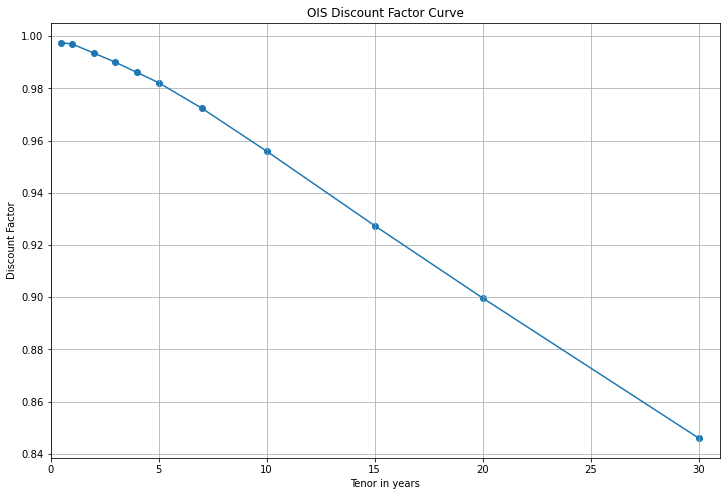

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('OIS Discount Factor Curve')
plt.plot(ois1['Tenor'],ois1['Do'])
plt.scatter(ois1['Tenor'],ois1['Do'])

plt.xlabel('Tenor in years')
plt.ylabel('Discount Factor')
plt.xlim(0,31)
plt.grid()
plt.show()

## LIBOR Discount Curve

In [38]:
ois_libor = ois
for i in range(60):
    j=(i+1)/2
    try:
        ois_libor.loc[j,'Do']
    except:
        ois_libor.loc[j,'Do']= (ois_libor.loc[j+0.5,'Do']+ois_libor.loc[j-0.5,'Do'])/2
ois_libor.sort_index(inplace=True)
ois_libor

,Tenor,Product,Rate,Do,fn
Tenor,,,,,
0.5,6m,OIS,0.00250,0.997506,0.004994
1.0,1y,OIS,0.00300,0.997009,0.000997
1.5,NaN,NaN,NaN,0.995270,NaN
2.0,2y,OIS,0.00325,0.993531,0.003495
2.5,NaN,NaN,NaN,0.991773,NaN
3.0,3y,OIS,0.00335,0.990015,0.003545
3.5,NaN,NaN,NaN,0.988066,NaN
4.0,4y,OIS,0.00350,0.986117,0.003946
4.5,NaN,NaN,NaN,0.984150,NaN


In [39]:
irs = pd.read_excel("IR Data.xlsx", sheet_name="IRS", usecols="A:C")
irs.index = irs['Tenor'].apply(lambda x: int(x.split('y')[0]) if 'y' in x else 0.5)
irs

,Tenor,Product,Rate
Tenor,,,
0.5,6m,LIBOR,0.0250
1.0,1y,IRS,0.0280
2.0,2y,IRS,0.0300
3.0,3y,IRS,0.0315
4.0,4y,IRS,0.0325
5.0,5y,IRS,0.0330
7.0,7y,IRS,0.0350
10.0,10y,IRS,0.0370
15.0,15y,IRS,0.0400


In [40]:
def libor_df_calculation(j):
    if j>0.5:
        return((irs.loc[j-0.5,'Dn']*(1/(1+0.5*irs.loc[j,'Li']))))
    elif j==0.5:
        return(1/(1+0.5*irs.loc[j,'Rate']))

In [41]:
def libor_df_calculation_Li(j,Li):
    if j>0.5:
        return((irs.loc[j-0.5,'Dn']*(1/(1+0.5*Li))))

In [42]:
def df_t(Li,j):
    return((2*irs.loc[j-0.5,'Dn']-Li)/3)

In [43]:
def base_form_libor(steps,j,Li,df_t_1):
    x=0
    for k in range(steps):
        if k ==0:
            x+=ois.loc[j,'Do']*Li
        else:
            libor=(2)*((k*libor_df_calculation_Li(j,Li)-(k-1)*df_t_1)/((k+1)*libor_df_calculation_Li(j,Li)-(k*df_t_1))-1)
            x+=ois.loc[j+(k/2),'Do']*libor
    return(x)

In [44]:
irs = pd.read_excel("IR Data.xlsx", sheet_name="IRS", usecols="A:C")
irs.index = irs['Tenor'].apply(lambda x: int(x.split('y')[0]) if 'y' in x else 0.5)

for i in range(60):
    j=(i+1)/2
    
    if j==0.5:
        irs.at[j,'Dn'] = 1/(1+0.5*(irs.loc[j,'Rate']))
        irs.at[j,'Li'] = irs.loc[j,'Rate']
        continue
        
    
    
    if j in irs['Tenor']:
        sum_of_df_Li = (ois.loc[ois.index<j]['Do']*irs.loc[irs.index<j]['Li']).sum()
        sum_of_df_fixed = ois.loc[ois.index<=j]['Do'].sum()
        Li = (2*(irs.loc[j,'Rate']*(0.5*sum_of_df_fixed))-(sum_of_df_Li))/(ois.loc[ois.index==j]['Do'])
        irs.at[j,'Li']=Li
        
    else:
        for index, row in irs.iterrows():
            #has to be first time running to work
            if index>j:
                rate=row['Rate']
                sum_of_df_fixed = ois.loc[ois.index<=index]['Do'].sum()
                steps = int((index-j)/0.5+1)
                break
        
        sum_of_df_Li = (ois.loc[ois.index<j]['Do']*irs.loc[irs.index<j]['Li']).sum()
        
        df_t_1 = irs.loc[j-0.5,'Dn']
        
        Li = brentq(lambda Li: rate*(0.5*(sum_of_df_fixed))-(0.5*(sum_of_df_Li+base_form_libor(steps,j,Li,df_t_1))) ,a=-0.0000001,b=0.1)
        irs.at[j,'Li']=Li
                    
    irs.at[j,'Dn']= libor_df_calculation(j)

In [45]:
irs.sort_index(inplace=True)
irs

,Tenor,Product,Rate,Dn,Li
Tenor,,,,,
0.5,6m,LIBOR,0.0250,0.987654,0.025000
1.0,1y,IRS,0.0280,0.972579,0.031001
1.5,NaN,NaN,NaN,0.957380,0.031750
2.0,2y,IRS,0.0300,0.942182,0.032262
2.5,NaN,NaN,NaN,0.926334,0.034217
3.0,3y,IRS,0.0315,0.910485,0.034813
3.5,NaN,NaN,NaN,0.894735,0.035206
4.0,4y,IRS,0.0325,0.878985,0.035837
4.5,NaN,NaN,NaN,0.863989,0.034713


In [53]:
irs1=irs.copy()
del irs1['Tenor']
irs1 = irs1.reset_index()
irs1 = irs1.dropna(how='any')
irs1

,Tenor,Product,Rate,Dn,Li
0,0.5,LIBOR,0.0250,0.987654,0.025000
1,1.0,IRS,0.0280,0.972579,0.031001
3,2.0,IRS,0.0300,0.942182,0.032262
5,3.0,IRS,0.0315,0.910485,0.034813
7,4.0,IRS,0.0325,0.878985,0.035837
9,5.0,IRS,0.0330,0.848993,0.035326
13,7.0,IRS,0.0350,0.784221,0.041297
19,10.0,IRS,0.0370,0.692733,0.044023
29,15.0,IRS,0.0400,0.551223,0.051344
39,20.0,IRS,0.0450,0.408479,0.069891


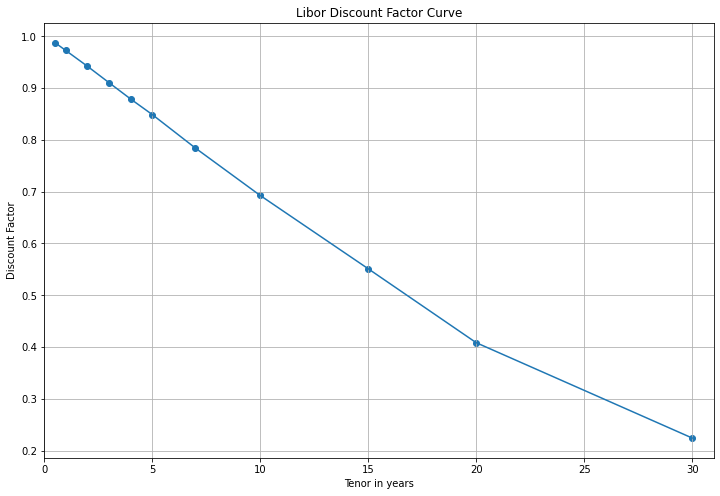

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Libor Discount Factor Curve')
plt.plot(irs1['Tenor'],irs1['Dn'])
plt.scatter(irs1['Tenor'],irs1['Dn'])

plt.xlabel('Tenor in years')
plt.ylabel('Discount Factor')
plt.xlim(0,31)
plt.grid()
plt.show()

## Forward Swap Rates

In [58]:
forward_swap_rates=pd.DataFrame(columns=["forward","tenor","forward_swap_rate"])
tenor_range = [1,2,3,5,10]
forward_range = [1,5,10]

for i in forward_range:
    for j in tenor_range:
        new_row = {"forward":i,"tenor":j}
        forward_swap_rates = forward_swap_rates.append(new_row,ignore_index=True)

for index, row in forward_swap_rates.iterrows():
    i=row['forward']
    j=row['tenor']
    sum_of_df_fixed = ois.loc[(ois.index>i)&(ois.index<=i+j)]['Do'].sum()
    sum_of_do_li = 0
    for k in range(int(j*2)):
        k=k/2+0.5
        sum_of_do_li += ois.loc[ois.index==i+k]['Do'].sum()*irs.loc[irs.index==i+k]['Li'].sum()

    forward_swap_rates.at[index,"forward_swap_rate"] = sum_of_do_li/sum_of_df_fixed

forward_swap_rates

,forward,tenor,forward_swap_rate
0,1.0,1.0,0.032006
1,1.0,2.0,0.033258
2,1.0,3.0,0.034010
3,1.0,5.0,0.035255
4,1.0,10.0,0.038423
5,5.0,1.0,0.039273
6,5.0,2.0,0.040074
7,5.0,3.0,0.040069
8,5.0,5.0,0.041089
9,5.0,10.0,0.043619


In [56]:
# forward swap expiry every 0.5 years

forward_swap_rates_all_years=pd.DataFrame(columns=["forward","tenor","forward_swap_rate"])
tenor_range = [1,2,3,4,5,6,7,8,9,10]
forward_range = [1,2,3,4,5,6,7,8,9,10]

for i in range(20):
    i=i/2+0.5
    for j in tenor_range:
        new_row = {"forward":i,"tenor":j}
        forward_swap_rates_all_years = forward_swap_rates_all_years.append(new_row,ignore_index=True)

for index, row in forward_swap_rates_all_years.iterrows():
    i=row['forward']
    j=row['tenor']
    sum_of_df_fixed = ois.loc[(ois.index>i)&(ois.index<=i+j)]['Do'].sum()
    sum_of_do_li = 0
    for k in range(int(j*2)):
        k=k/2+0.5
        sum_of_do_li += ois.loc[ois.index==i+k]['Do'].sum()*irs.loc[irs.index==i+k]['Li'].sum()

    forward_swap_rates_all_years.at[index,"forward_swap_rate"] = sum_of_do_li/sum_of_df_fixed

forward_swap_rates_all_years

,forward,tenor,forward_swap_rate
0,0.5,1.0,0.031375
1,0.5,2.0,0.032305
2,0.5,3.0,0.033204
3,0.5,4.0,0.033719
4,0.5,5.0,0.034391
...,...,...,...
195,10.0,6.0,0.047464
196,10.0,7.0,0.048796
197,10.0,8.0,0.050222
198,10.0,9.0,0.051761


In [57]:
forward_swap_rates_all_years.to_csv("forward_swap_rates_all_years.csv")

In [59]:
#interpolate LIBOR discount factor
from scipy import interpolate
y = irs['Dn'].to_list()
y.insert(0,1)
x = irs.index.to_list()
x.insert(0,0)
libor_df = interpolate.interp1d(x,y)

In [60]:
ois_3m = ois.copy()
for i in range(120):
    j=(i+1)/4
    if j==0.25:
        ois_3m.loc[j,'Do']= (ois_3m.loc[j+0.25,'Do']+1)/2
    else:
        try:
            ois_3m.loc[j,'Do']
        except:
            ois_3m.loc[j,'Do']= (ois_3m.loc[j+0.25,'Do']+ois_3m.loc[j-0.25,'Do'])/2
ois_3m.sort_index(inplace=True)
ois_3m

,Tenor,Product,Rate,Do,fn
Tenor,,,,,
0.25,NaN,NaN,NaN,0.998753,NaN
0.50,6m,OIS,0.0025,0.997506,0.004994
0.75,NaN,NaN,NaN,0.997258,NaN
1.00,1y,OIS,0.0030,0.997009,0.000997
1.25,NaN,NaN,NaN,0.996139,NaN
...,...,...,...,...,...
29.00,NaN,NaN,NaN,0.892452,0.000904
29.25,NaN,NaN,NaN,0.880852,NaN
29.50,NaN,NaN,NaN,0.869252,NaN


In [42]:
ois_3m.to_csv('ois_3m.csv')

In [61]:
irs_libor = irs.copy()
for i in range(120):
    j=(i+1)/4
    try:
        irs_libor.loc[j,'Dn']
    except:
        irs_libor.loc[j,'Dn']= libor_df(j)
irs_libor.sort_index(inplace=True)
irs_libor['6m_Li_3m'] = np.NaN

for i in range(60):
    i=(i*0.5)+0.25
    if i == 0.25:
        continue
    else:
        j=i-0.50
        irs_libor.at[i,'6m_Li_3m'] = (1/0.5)*((irs_libor['Dn'][j]-irs_libor['Dn'][i])/irs_libor['Dn'][i])

In [62]:
import math
irs_libor['6m_Li']=np.NaN
for i in range(120):
    i=(i+1)*0.25
    if i ==0.25:
        continue
    if math.isnan(irs_libor['Li'][i]):
        irs_libor.at[i,'6m_Li']=irs_libor['6m_Li_3m'][i]
    else:
        irs_libor.at[i,'6m_Li']=irs_libor['Li'][i]


In [63]:
#Calculate semi-annual forward swap rate at every 3 months interval
forward_swap_6m_rates_3m=pd.DataFrame(columns=["forward","tenor","forward_swap_rate"])
tenor_range = [1,2,3,4,5,6,7,8,9,10]

for i in range(40):
    i=i/4+0.25
    for j in tenor_range:
        new_row = {"forward":i,"tenor":j}
        forward_swap_6m_rates_3m = forward_swap_6m_rates_3m.append(new_row,ignore_index=True)

for index, row in forward_swap_6m_rates_3m.iterrows():
    i=row['forward']
    j=row['tenor']

    sum_of_df_fixed = 0
    sum_of_do_li = 0
    for k in range(int(j*2)):
        k=k/2+0.5
        sum_of_df_fixed += ois_3m.loc[ois_3m.index==i+k]['Do'].sum()
        sum_of_do_li += ois_3m.loc[ois_3m.index==i+k]['Do'].sum()*irs_libor.loc[irs_libor.index==i+k]['6m_Li'].sum()

    forward_swap_6m_rates_3m.at[index,"forward_swap_rate"] = sum_of_do_li/sum_of_df_fixed
    
forward_swap_6m_rates_3m

,forward,tenor,forward_swap_rate
0,0.25,1.0,0.029674
1,0.25,2.0,0.031143
2,0.25,3.0,0.032345
3,0.25,4.0,0.033104
4,0.25,5.0,0.033689
...,...,...,...
395,10.00,6.0,0.047464
396,10.00,7.0,0.048796
397,10.00,8.0,0.050222
398,10.00,9.0,0.051761


In [64]:
forward_swap_6m_rates_3m.to_csv("forward_swap_6m_rates_3m.csv")

In [66]:
irs_libor

,Tenor,Product,Rate,Dn,Li,6m_Li_3m,6m_Li
Tenor,,,,,,,
0.25,NaN,NaN,NaN,0.993827,NaN,NaN,NaN
0.50,6m,LIBOR,0.025,0.987654,0.025000,NaN,0.025000
0.75,NaN,NaN,NaN,0.980116,NaN,0.027978,0.027978
1.00,1y,IRS,0.028,0.972579,0.031001,NaN,0.031001
1.25,NaN,NaN,NaN,0.964979,NaN,0.031373,0.031373
...,...,...,...,...,...,...,...
29.00,NaN,NaN,NaN,0.242822,0.075802,NaN,0.075802
29.25,NaN,NaN,NaN,0.238221,NaN,0.077266,0.077266
29.50,NaN,NaN,NaN,0.233619,0.078788,NaN,0.078788


In [65]:
irs_libor.to_csv('irs_libor.csv')